In [18]:
#!/usr/bin/env python
# coding: utf-8
import pyscf
from pyscf import gto,dft,scf
import torch
torch.set_default_dtype(torch.double)
import pyscf
from pyscf import gto,dft,scf

import numpy as np
import scipy
from ase import Atoms
from ase.io import read
from dpyscf.net import *
from dpyscf.torch_routines import *
from dpyscf.utils import *
from dpyscf.losses import *
from pyscf.cc import CCSD
from functools import partial
from ase.units import Bohr
from datetime import datetime
import sys
import shutil
import os
import psutil
import gc
import tarfile
import argparse
import json
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/gpfs/home/smdick/miniconda3/envs/torch/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['datetime', 'eig']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [57]:
atoms = read('../data/haunschild_g2/g2_97.traj',':')

def get_rhos(a_idx, dm_path):
    with open(dm_path, 'rb') as file:
        dms_pred = pickle.load(file)
    errors = []



    a = atoms[a_idx]



    basis = '6-311++G(3df,2pd)'
    spin = a.info.get('spin', 0)
    pos = a.positions
    this_basis = basis
    spec = a.get_chemical_symbols()
    mol_input = [[s, p] for s, p in zip(spec, pos)]
    try:
        mol = gto.M(atom=mol_input, basis=this_basis,spin=spin)
    except Exception:
        spin =1
        mol = gto.M(atom=mol_input, basis=this_basis,spin=spin)


    mf = dft.UKS(mol)
    mf.xc = 'PBE'
    mf.grids.level = 7
    mf.grids.build()

    N = 100
    z = np.linspace(-4, 4, N)
    x = np.linspace(-4, 4, N)
    X,Z = np.meshgrid(z,x)
    mf.grids.coords = np.stack([X.flatten(),np.zeros_like(X.flatten()), Z.flatten()],axis=-1)

    mf.grids.weights = np.zeros(N)
    dm = dms_pred[a_idx]
    dm_ref = np.load('../data/ccsdt/{}.dm.npy'.format(a_idx))

    #     for s in [0,1]:
    rho_ref = get_rho(mf,mol,np.sum(dm_ref, axis=0), mf.grids)
    rho = get_rho(mf,mol,np.sum(dm,axis=0), mf.grids)
    return rho.reshape(N,N), rho_ref.reshape(N,N)

In [58]:
a_idx = np.where([str(a.symbols)=='NO' for a in atoms])[0][0]


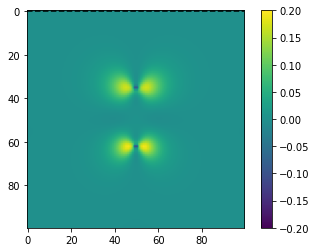

In [64]:
rho, rho_ref = get_rhos(a_idx, '../exp/test_g2_gga2/GGA_2_g2.dm')
axhline(0, color='black',ls='--')
# plot(z, rho_ref-rho)
imshow(rho_ref - rho, vmin=-0.2,vmax=0.2)
colorbar()

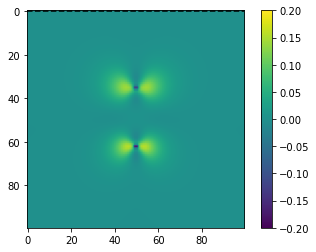

In [65]:
rho, rho_ref = get_rhos(a_idx, '../exp/test_g2_pbe/PBE_g2.dm')
axhline(0, color='black',ls='--')
imshow(rho_ref-rho, vmin=-0.2,vmax=0.2)
colorbar()